# Carpole

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, input_size, output_size, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, lr=0.001):
        self.input_size = input_size
        self.output_size = output_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lr = lr
        self.policy_net = DQN(input_size, output_size)
        self.target_net = DQN(input_size, output_size)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.output_size)
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            return self.policy_net(state).argmax().item()

    def train(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).unsqueeze(0)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        action = torch.tensor([action])
        reward = torch.tensor([reward], dtype=torch.float32)
        target = reward + self.gamma * torch.max(self.target_net(next_state).detach()) * (1 - done)
        q_val = self.policy_net(state).gather(1, action.unsqueeze(1))
        loss = self.loss_fn(q_val, target.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

env = gym.make('CartPole-v1')
agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)

for episode in range(3000):
    state, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        agent.train(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)

    if episode % 10 == 0:
        agent.update_target_net()
        print(f"Episode: {episode}, Total Reward: {total_reward}")

env.close()

In [2]:
!pip install ufal.pybox2d 

Defaulting to user installation because normal site-packages is not writeable


# Lunar Lander

In [53]:
import gymnasium as gym

env = gym.make('LunarLander-v2',
            gravity=-10.0,
            enable_wind=True,
            wind_power=15.0,
            turbulence_power=1.5,
            max_episode_steps=600,)
env.reset(seed=42)

# Play one complete episode with random actions
while True:
    action = env.action_space.sample() 
    _, _, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break
    
env.close()

In [54]:
"""
import torch

class DQN(torch.nn.Module):
    def __init__(self, state_size=8, action_size=4, hidden_size=64, activation=torch.relu):
        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(state_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer3 = torch.nn.Linear(hidden_size, action_size)
        self.activation = activation

    def forward(self, state):
        x = self.activation(self.layer1(state))
        x = self.activation(self.layer2(x))
        return self.layer3(x)
"""

'\nimport torch\n\nclass DQN(torch.nn.Module):\n    def __init__(self, state_size=8, action_size=4, hidden_size=64, activation=torch.relu):\n        super(DQN, self).__init__()\n        self.layer1 = torch.nn.Linear(state_size, hidden_size)\n        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)\n        self.layer3 = torch.nn.Linear(hidden_size, action_size)\n        self.activation = activation\n\n    def forward(self, state):\n        x = self.activation(self.layer1(state))\n        x = self.activation(self.layer2(x))\n        return self.layer3(x)\n'

In [63]:
import torch

class DQN(torch.nn.Module):
    def __init__(self, state_size=8, action_size=4, hidden_size=64, num_hidden_layers=2, activation=torch.relu):
        super(DQN, self).__init__()
        self.num_hidden_layers = num_hidden_layers
        
        # Define the input layer
        self.input_layer = torch.nn.Linear(state_size, hidden_size)
        
        # Define the hidden layers
        self.hidden_layers = torch.nn.ModuleList([
            torch.nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)
        ])
        
        # Define the output layer
        self.output_layer = torch.nn.Linear(hidden_size, action_size)
        
        # Activation function
        self.activation = activation

    def forward(self, state):
        x = self.activation(self.input_layer(state))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        return self.output_layer(x)


In [64]:
import numpy as np
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, buffer_size=10000):
        self.buffer = deque(maxlen=buffer_size)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.stack(states), actions, rewards, np.stack(next_states), dones

    def __len__(self):
        return len(self.buffer)

In [65]:
class DQNAgent:
    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64, optimizer='adam', activation=torch.relu, num_hidden_layers=2):
        # Select device to train on (if CUDA available, use it, otherwise use CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Discount factor for future rewards
        self.gamma = gamma

        # Batch size for sampling from the replay memory
        self.batch_size = batch_size

        # Number of possible actions
        self.action_size = action_size

        # Initialize the Q-Network and Target Network with the given state size, action size and hidden layer size
        # Move the networks to the selected device
        self.q_network = DQN(state_size, action_size, hidden_size, activation=activation).to(self.device)
        self.target_network = DQN(state_size, action_size, hidden_size, activation=activation).to(self.device)
        
        # Set weights of target network to be the same as those of the q network
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Set target network to evaluation mode
        self.target_network.eval()

        if optimizer == 'adam':
            self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        elif optimizer == 'sgd':
            self.optimizer = optim.SGD(self.q_network.parameters(), lr=learning_rate)
        
        # Initialize the replay memory
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        # Store the experience in memory
        self.memory.push(state, action, reward, next_state, done)
        
        # If there are enough experiences in memory, perform a learning step
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        # If a randomly chosen value is greater than eps
        if random.random() > eps:  
            # Convert state to a PyTorch tensor and set network to evaluation mode
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()  

            # With no gradient updates, get the action values from the DQN
            with torch.no_grad():
                action_values = self.q_network(state)

            # Revert to training mode and return action
            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            # Return a random action for random value > eps
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):
        # Sample a batch of experiences from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert numpy arrays to PyTorch tensors
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        
        # Get maximum Q-value for the next states from target network
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        
        # Compute the expected Q-values
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute the loss between the current and expected Q values
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        
        # Zero all gradients
        self.optimizer.zero_grad()
        
        # Backpropagate the loss
        loss.backward()
        
        # Step the optimizer
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [90]:
from collections import deque

def train(agent, env, n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_update=10):
    # Initialize the scores list and scores window
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start

    # Loop over episodes
    for i_episode in range(1, n_episodes + 1):
        
        # Reset environment and score at the start of each episode
        state, _ = env.reset()
        score = 0 

        # Loop over steps
        while True:
            
            # Select an action using current agent policy then apply in environment
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action) 
            done = terminated or truncated
            
            # Update the agent, state, and score
            agent.step(state, action, reward, next_state, done)
            state = next_state 
            score += reward

            # End the episode if done
            if done:
                break 
        
        # At the end of episode append and save scores
        scores_window.append(score)
        scores.append(score) 

        # Decrease epsilon
        eps = max(eps_end, eps_decay * eps)

        # Update target network every target_update episodes
        if i_episode % target_update == 0:
            agent.update_target_network()
            
        # Print average score every 100 episodes
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        # This environment is considered to be solved for a mean score of 200 or greater, so stop training.
        if i_episode % 100 == 0 and np.mean(scores_window) >= 200:
            break

    return scores

In [88]:
def plot_scores(scores, title):
    plt.figure(figsize=(10, 5))
    plt.plot(scores, color='b', linestyle='-')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()


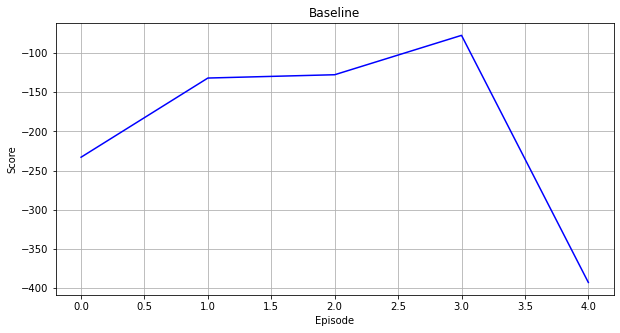

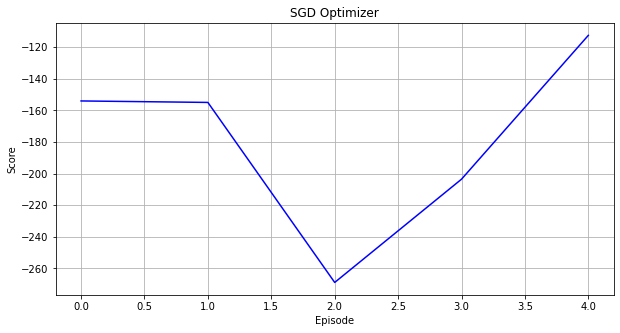

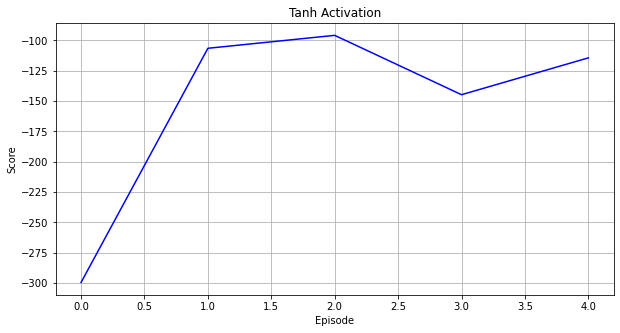

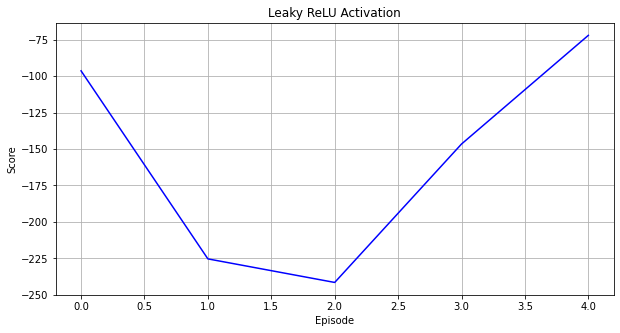

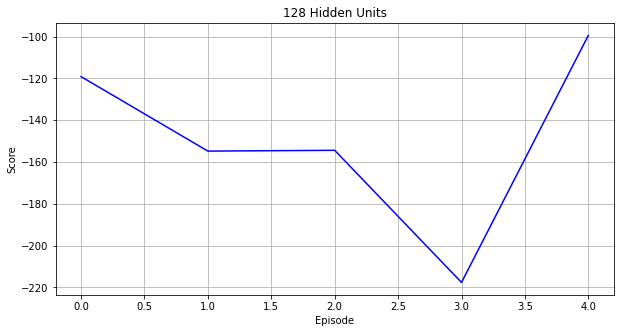

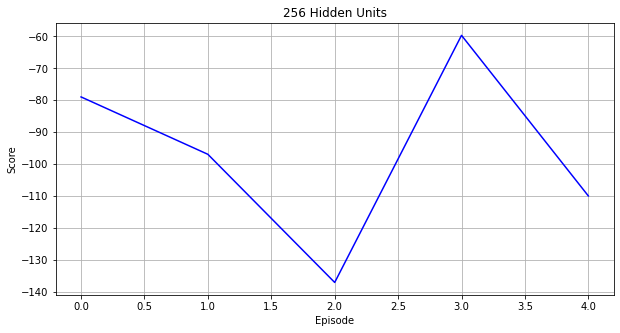

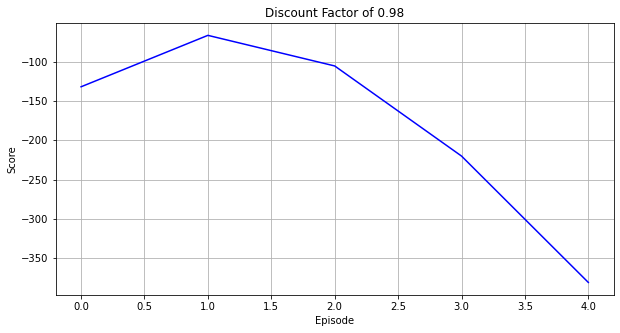

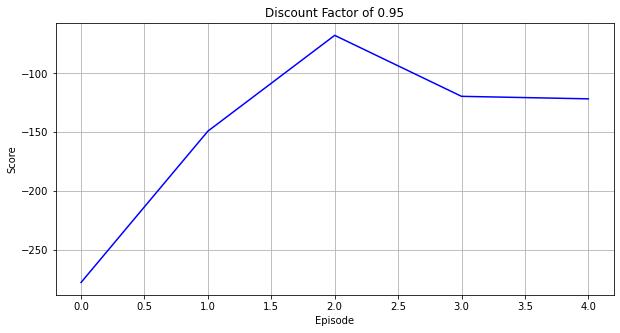

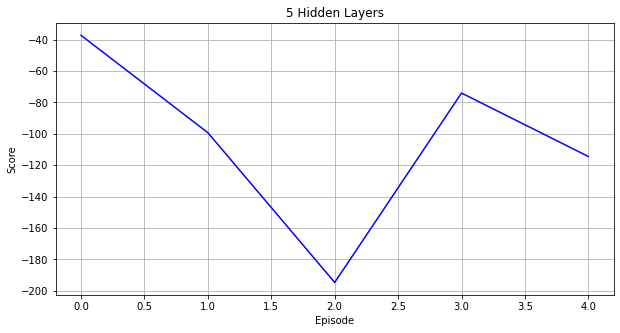

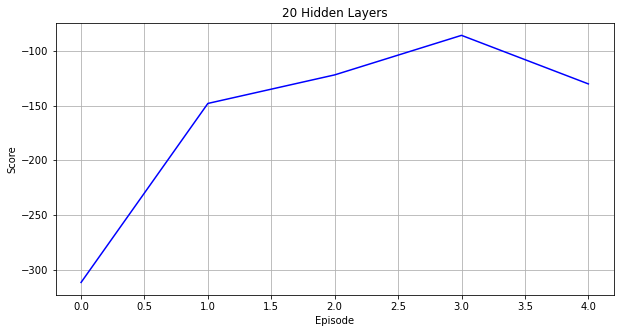

In [89]:
# Define a function to train and plot scores
def train_and_plot(agent, env, title):
    scores = train(agent, env)
    plot_scores(scores, title)

# Make an environment
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Create agents with different configurations
agent_baseline = DQNAgent(state_size, action_size, optimizer='adam')
agent_sgd = DQNAgent(state_size, action_size, optimizer='sgd')
agent_tanh = DQNAgent(state_size, action_size, activation=torch.tanh)
agent_leaky_ReLU = DQNAgent(state_size, action_size, activation=torch.nn.LeakyReLU()) # Default negative slope of .01
agent_128 = DQNAgent(state_size, action_size, hidden_size=128)
agent_256 = DQNAgent(state_size, action_size, hidden_size=256)
agent_gamma_98 = DQNAgent(state_size, action_size, gamma=0.98)
agent_gamma_95 = DQNAgent(state_size, action_size, gamma=0.95)
agent_hidden_5 = DQNAgent(state_size, action_size, num_hidden_layers=5)
agent_hidden_20 = DQNAgent(state_size, action_size, num_hidden_layers=20)

# Train and plot scores for each agent
train_and_plot(agent_baseline, env, "Baseline")
train_and_plot(agent_sgd, env, "SGD Optimizer")
train_and_plot(agent_tanh, env, "Tanh Activation")
train_and_plot(agent_leaky_ReLU, env, "Leaky ReLU Activation")
train_and_plot(agent_128, env, "128 Hidden Units")
train_and_plot(agent_256, env, "256 Hidden Units")
train_and_plot(agent_gamma_98, env, "Discount Factor of 0.98")
train_and_plot(agent_gamma_95, env, "Discount Factor of 0.95")
train_and_plot(agent_hidden_5, env, "5 Hidden Layers")
train_and_plot(agent_hidden_20, env, "20 Hidden Layers")
